In [1]:
import pandas as pd

In [2]:
#Using train data
data = pd.read_csv('/Users/anastasiakurakova/Desktop/Data/diabetes/diabetes_train.csv')
X_test = pd.read_csv("/Users/anastasiakurakova/Desktop/Data/diabetes/diabetes_test.csv")
data.head()

gender   age  hypertension  heart_disease smoking_history    bmi  \
0    Male  73.0             0              0          former  24.77   
1    Male  80.0             0              0           never  24.60   
2  Female  38.0             0              0            ever  24.33   
3  Female  26.0             0              0     not current  18.87   
4  Female  61.0             1              0         current  22.11   

   HbA1c_level  blood_glucose_level  diabetes  
0          3.5                   80         0  
1          5.7                  145         1  
2          4.0                  158         0  
3          5.0                  100         0  
4          4.5                   85         0

In [3]:
data.shape

(80000, 9)

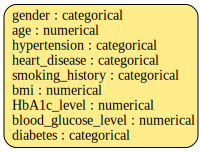

In [5]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)
metadata.visualize()

In [6]:
%%time
from sdv.single_table import TVAESynthesizer
model = TVAESynthesizer(metadata, epochs=300)
model.fit(data)

CPU times: user 8min 7s, sys: 3min 32s, total: 11min 40s
Wall time: 7min 40s


In [7]:
import plotly.express as px
loss_values = model.get_loss_values()
loss_values_reformatted = pd.melt(
    loss_values,
    id_vars=['Epoch'],
    var_name='Loss Type'
)

fig = px.line(loss_values_reformatted, x="Epoch", y="value", color="Loss Type", title='Epoch vs. Loss')
fig.show()

In [8]:
synthetic_data = model.sample(len(data))
synthetic_data.head()

gender    age  hypertension  heart_disease smoking_history    bmi  \
0    Male  79.63             0              0            ever  35.44   
1    Male  45.73             0              0           never  26.83   
2  Female  21.19             0              0           never  17.12   
3  Female  24.38             0              0         current  21.98   
4  Female  58.67             0              0           never  42.77   

   HbA1c_level  blood_glucose_level  diabetes  
0          5.0                  140         0  
1          6.6                  200         0  
2          6.6                  158         0  
3          5.0                  160         0  
4          6.2                  255         1

In [87]:
#synthetic_data.to_csv('/Users/anastasiakurakova/Desktop/Data/diabetes/diabetes_synthetic_TVAE_TSTR.csv', index=False)

In [9]:
# Find common duplicate rows between df1 and df2
common_duplicates = pd.merge(X_test, synthetic_data, how='inner')
new = common_duplicates.drop_duplicates()
# Print the common duplicate rows
print("Common Duplicate Rows:")
print(common_duplicates)
print(new)

Common Duplicate Rows:
    gender   age  hypertension  heart_disease smoking_history    bmi  \
0   Female  80.0             0              0         No Info  27.32   
1   Female  80.0             0              0         No Info  27.32   
2     Male  80.0             0              0         No Info  27.32   
3     Male  80.0             0              0         No Info  27.32   
4     Male  80.0             0              0         No Info  27.32   
5     Male  80.0             0              0         No Info  27.32   
6     Male  80.0             0              0         No Info  27.32   
7   Female  80.0             0              0         No Info  27.32   
8   Female  80.0             0              0         No Info  27.32   
9     Male  80.0             0              0         No Info  27.32   
10    Male  80.0             0              0         No Info  27.32   
11    Male  80.0             0              0         No Info  27.32   
12    Male  80.0             0           

### Data Evaluation Using SDV Library

In [10]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

diagnostic = run_diagnostic(
    real_data=X_test,
    synthetic_data=synthetic_data,
    metadata=metadata
)
quality_report = evaluate_quality(
    X_test,
    synthetic_data,
    metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 339.02it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 36/36 [00:01<00:00, 18.80it/s]

Overall Score: 90.38%

Properties:
- Column Shapes: 94.07%
- Column Pair Trends: 86.68%


In [11]:
quality_report.get_details('Column Shapes')

Column        Metric     Score
0               gender  TVComplement  0.992600
1                  age  KSComplement  0.865675
2         hypertension  TVComplement  0.964712
3        heart_disease  TVComplement  0.992325
4      smoking_history  TVComplement  0.944275
5                  bmi  KSComplement  0.910075
6          HbA1c_level  KSComplement  0.895800
7  blood_glucose_level  KSComplement  0.913025
8             diabetes  TVComplement  0.987737

### Calculate Range Coverage and KSComplement for Numerical Variables

In [14]:
from sdmetrics.single_column import RangeCoverage, KSComplement
for i in ['bmi','HbA1c_level']:
  range_cov = RangeCoverage.compute(
      real_data=X_test[i],
      synthetic_data=synthetic_data[i]
  )
  ks = KSComplement.compute(
      real_data=X_test[i],
      synthetic_data=synthetic_data[i]
  )
  print(f"Range coverage for {i} is: {range_cov}")
  print(f"KSComplement for {i} is: {ks}")

Range coverage for bmi is: 0.5980116959064328
KSComplement for bmi is: 0.910075
Range coverage for HbA1c_level is: 1.0
KSComplement for HbA1c_level is: 0.8957999999999999


### Calculate Category Coverage and TVComplement for Categorical Variables

In [15]:

from sdmetrics.single_column import CategoryCoverage, TVComplement
for i in ['smoking_history','diabetes']:
  cat_cov = CategoryCoverage.compute(
    real_data=X_test[i],
    synthetic_data=synthetic_data[i]
  )
  tv = TVComplement.compute(
      real_data=X_test[i],
      synthetic_data=synthetic_data[i]
  )
  print(f"Category coverage for {i} is: {cat_cov}")
  print(f"TVComplement for {i} is: {tv}")

Category coverage for smoking_history is: 1.0
TVComplement for smoking_history is: 0.944275
Category coverage for diabetes is: 1.0
TVComplement for diabetes is: 0.9877374999999999


### Evaluation using Table Evaluator

(20000, 9) (80000, 9)


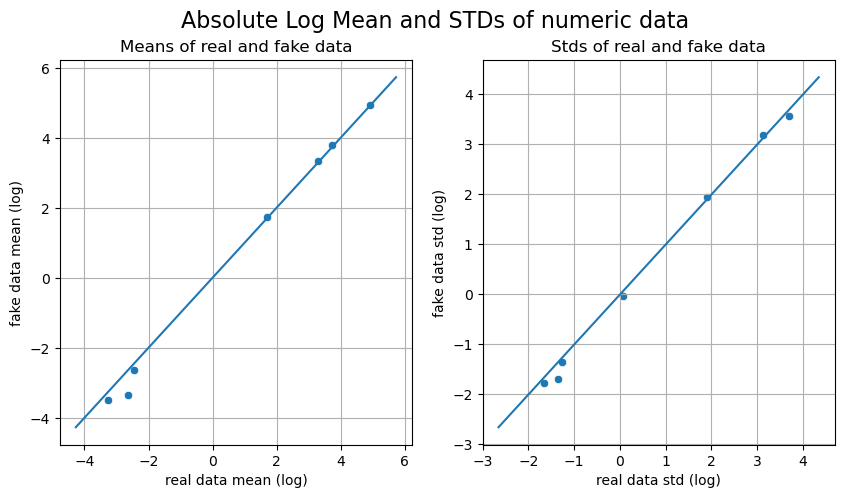

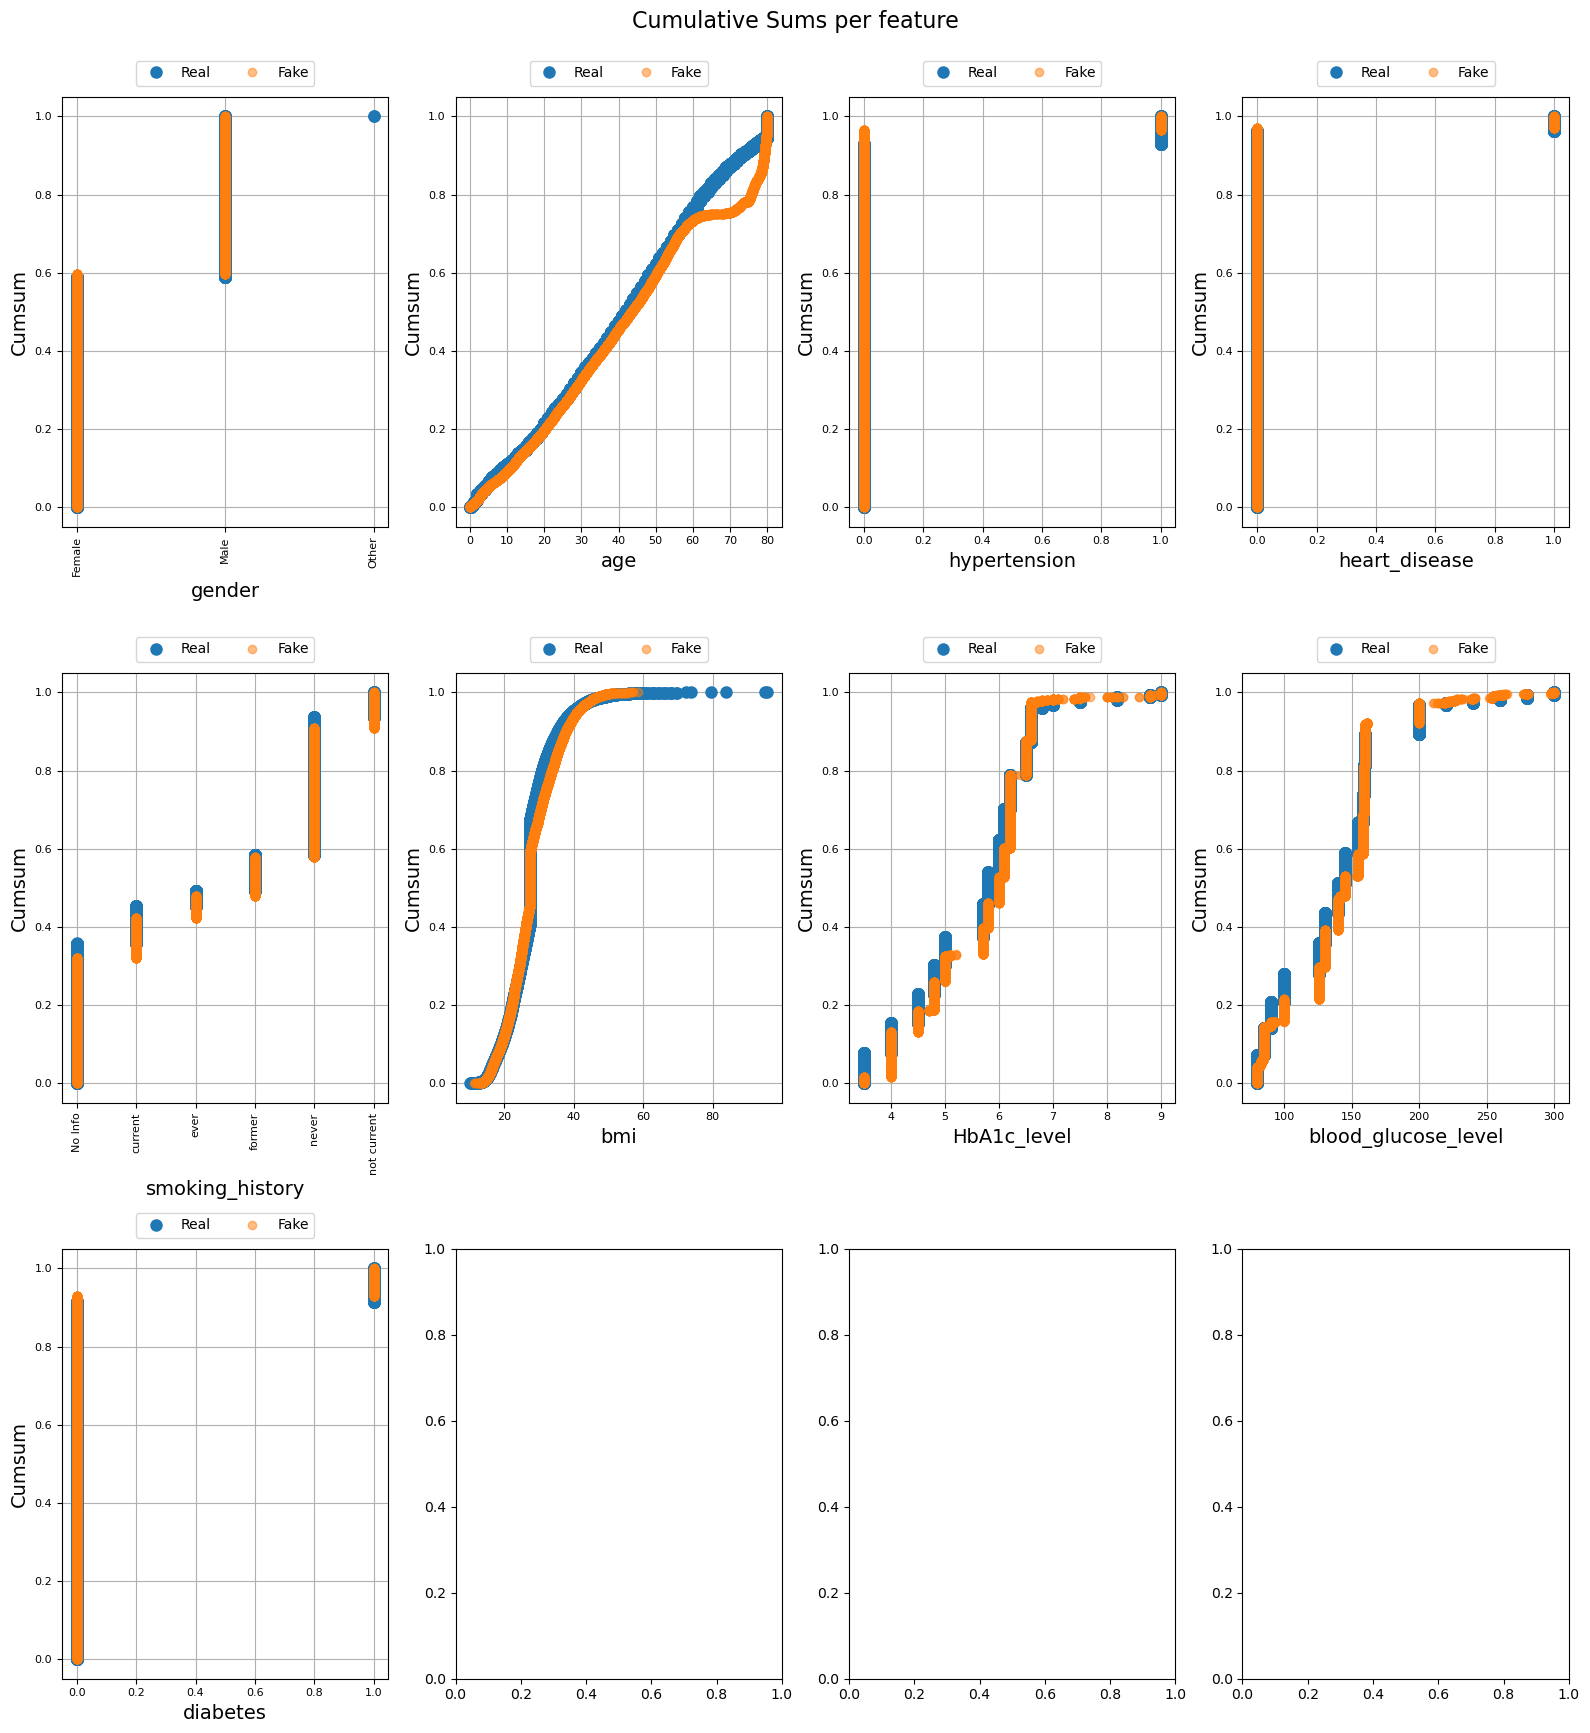

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



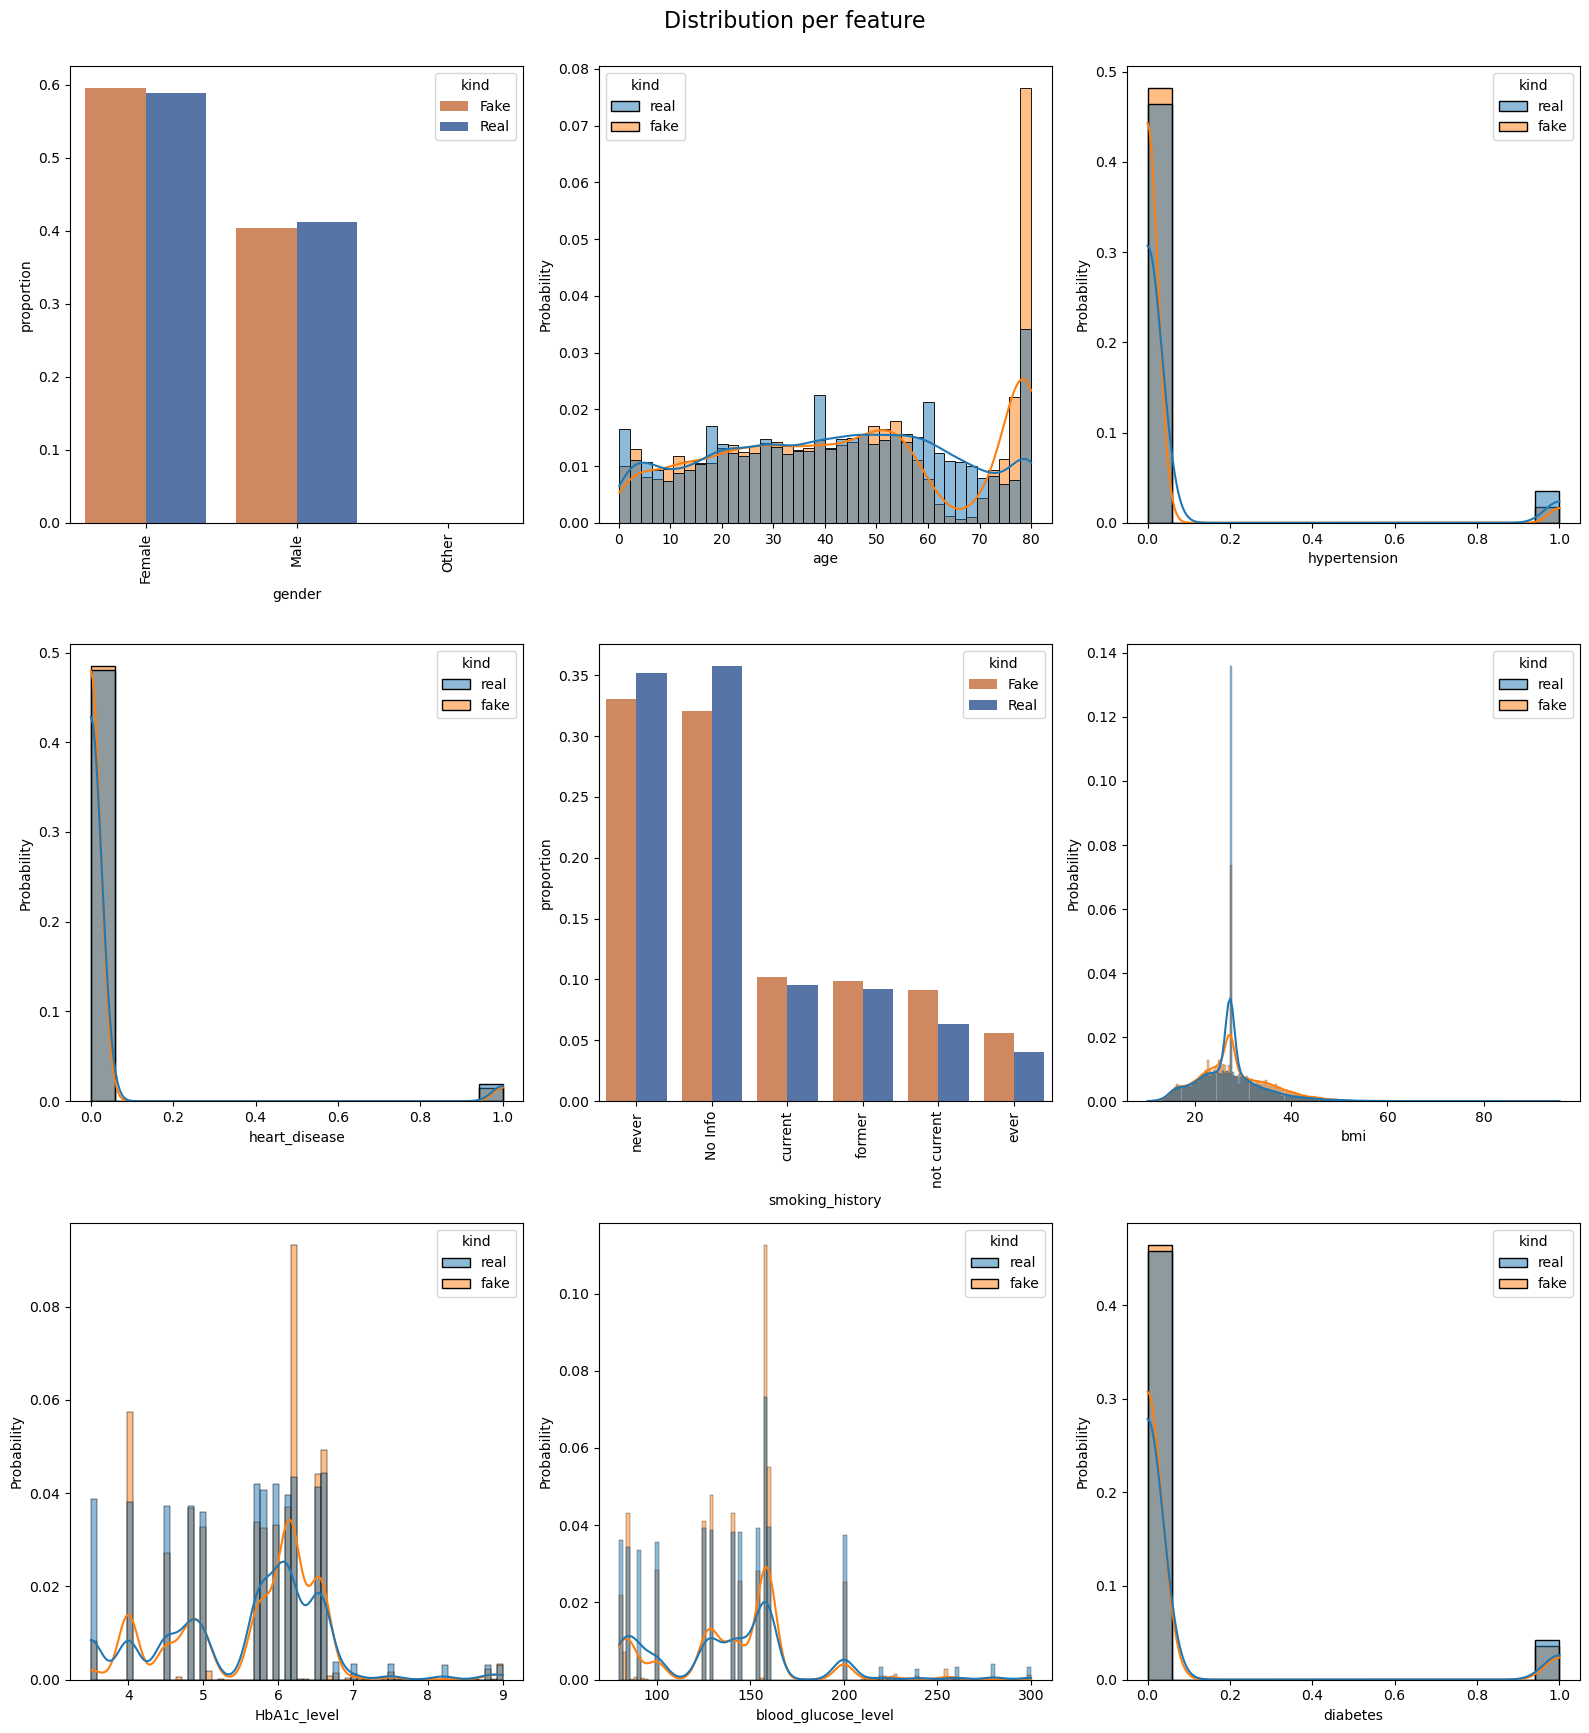

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:705: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython

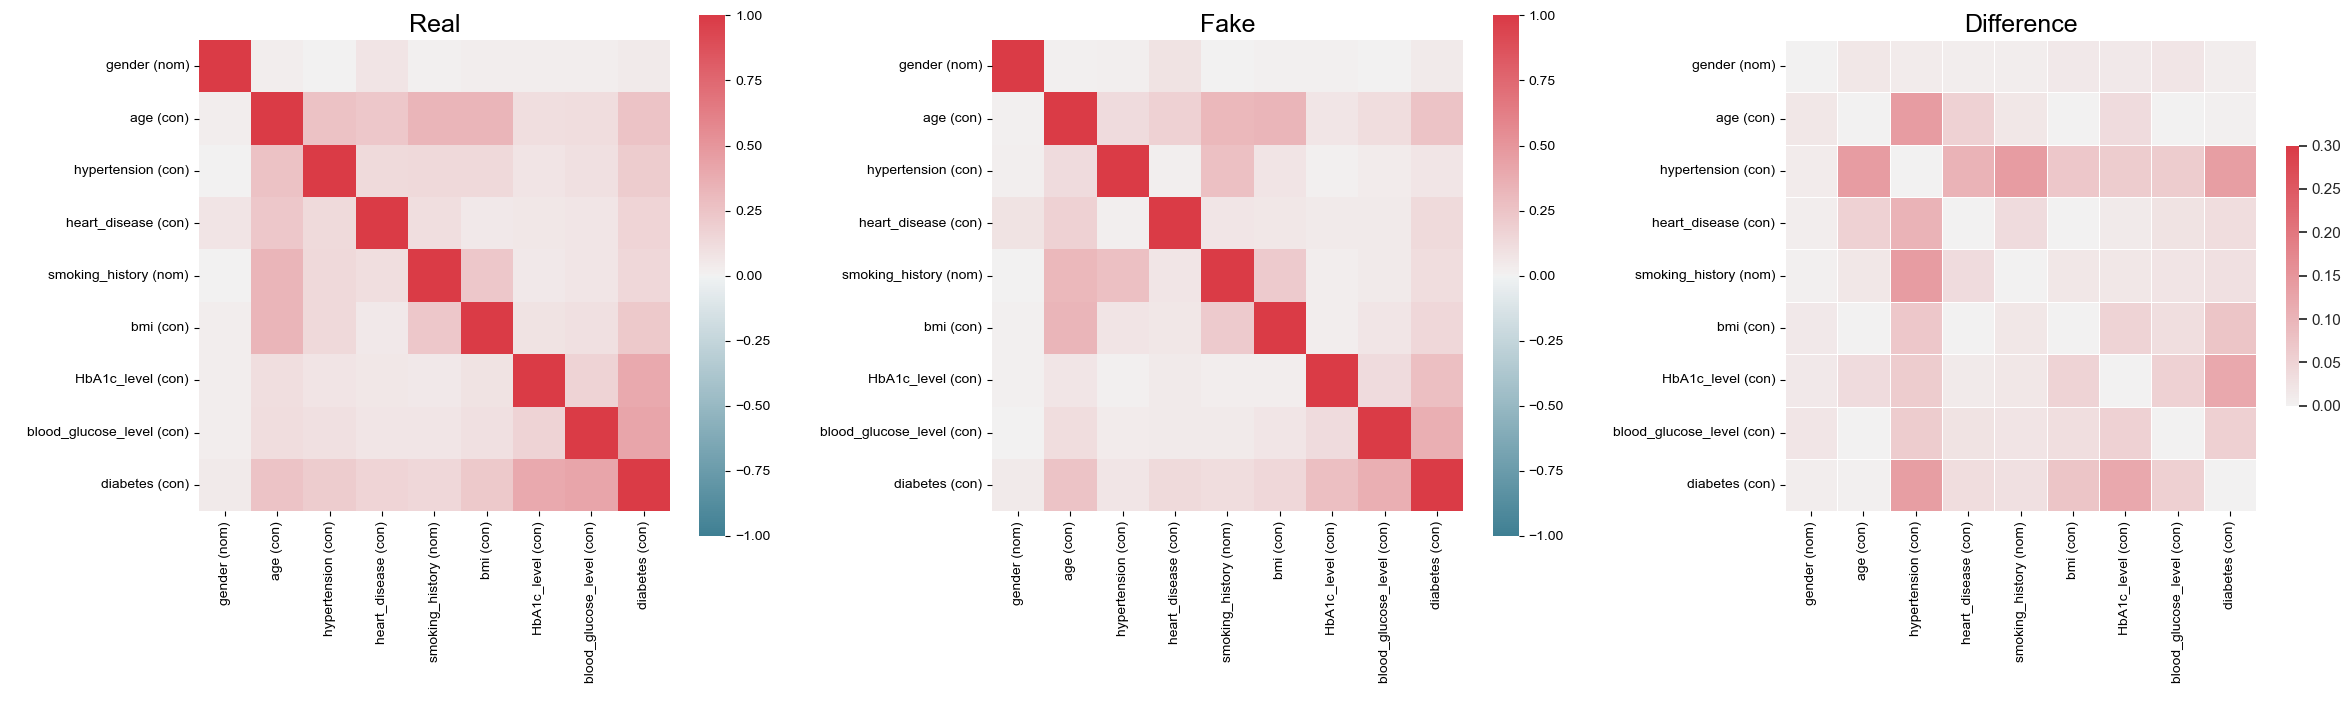

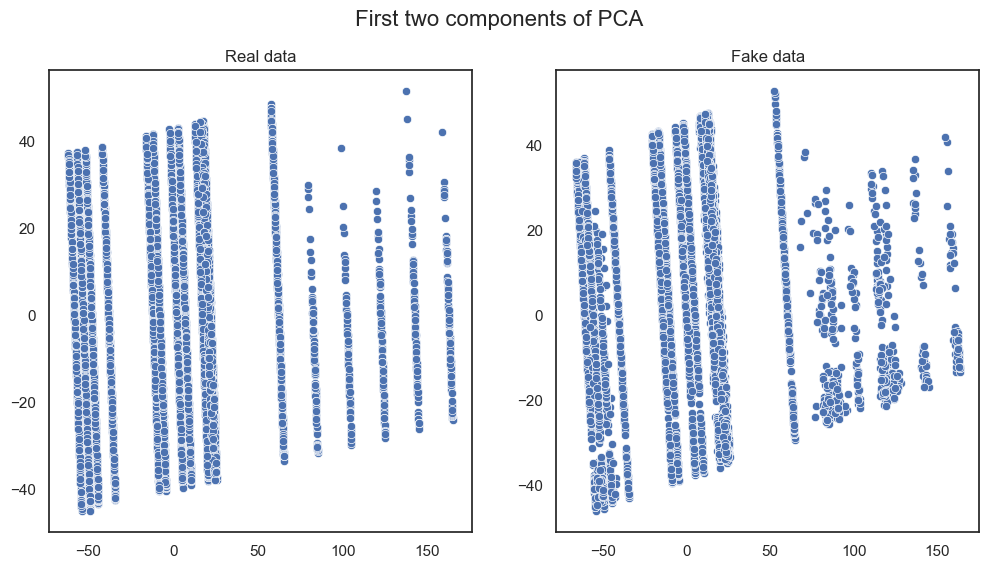

In [17]:
from table_evaluator import TableEvaluator
print(X_test.shape,synthetic_data.shape)
table_evaluator = TableEvaluator(X_test,synthetic_data[:len(X_test)])
table_evaluator.visual_evaluation()

In [18]:
table_evaluator.evaluate(target_col='smoking_history')

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:705: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.3013   0.3115              0.1723
DecisionTreeClassifier_real   0.3635   0.3210              0.1840
LogisticRegression_fake       0.4045   0.4068              0.7734
LogisticRegression_real       0.4452   0.4363              0.7505
MLPClassifier_fake            0.4027   0.4025              0.5244
MLPClassifier_real            0.4655   0.4442              0.5355
RandomForestClassifier_fake   0.3490   0.3485              0.2664
RandomForestClassifier_real   0.4120   0.3830              0.2780

Privacy results:
                                           result
Duplicate rows between sets (real/fake)  (378, 2)
nearest neighbor mean                      1.0774
nearest neighbor std                       0.1519

Miscellaneous results:
                                  Result
Co

#### Finding Wassetstein Distance and KL Divergence (Testing/Training vs Testing/Synthetic)

In [19]:
# Finding Wasserstein Distance
from scipy.stats import wasserstein_distance
wasserstein_distances = {}
for column in X_test.columns[5:]:
    wasserstein_dist = wasserstein_distance(X_test[column], synthetic_data[column])
    wasserstein_distances[column] = wasserstein_dist
    # Print Wasserstein distances for each feature
for column, distance in wasserstein_distances.items():
    print(f'For Testing data vs Synthetic Data {column}: {distance}')

For Testing data vs Synthetic Data bmi: 1.0095892499999994
For Testing data vs Synthetic Data HbA1c_level: 0.15040499999999998
For Testing data vs Synthetic Data blood_glucose_level: 5.8127875000000016
For Testing data vs Synthetic Data diabetes: 0.012262500000000065


In [20]:
wasserstein_distances = {}
for column in X_test.columns[5:]:
    wasserstein_dist = wasserstein_distance(X_test[column], data[column])
    wasserstein_distances[column] = wasserstein_dist
# Print Wasserstein distances for each feature
for column, distance in wasserstein_distances.items():
    print(f'Comparing Testing data and Training Data {column}: {distance}')

Comparing Testing data and Training Data bmi: 0.0843502499999998
Comparing Testing data and Training Data HbA1c_level: 0.01321375000000007
Comparing Testing data and Training Data blood_glucose_level: 0.2424875000000038
Comparing Testing data and Training Data diabetes: 0.000500000000000056


In [25]:
# Calculate KL Divergence for Testing vs Synthetic
from scipy.stats import entropy
kl_divergences = {}
for column in X_test.columns[5:]:
    kl_divergence = entropy(X_test[column], synthetic_data[:20000][column])
    kl_divergences[column] = kl_divergence

# Print KL Divergences for each feature
for column, divergence in kl_divergences.items():
    print(f' For Testing vs Synthetic Data {column}: {divergence}')

 For Testing vs Synthetic Data bmi: 0.06093370260521368
 For Testing vs Synthetic Data HbA1c_level: 0.03448491947063501
 For Testing vs Synthetic Data blood_glucose_level: 0.07575150681670847
 For Testing vs Synthetic Data diabetes: inf


In [27]:
# Calculate KL Divergence for Testing vs Training
from scipy.stats import entropy
kl_divergences = {}
for column in X_test.columns[5:]:
    kl_divergence = entropy(X_test[column], data[:20000][column])
    kl_divergences[column] = kl_divergence

# Print KL Divergences for each feature
for column, divergence in kl_divergences.items():
    print(f'For Testing vs Training Data {column}: {divergence}')

For Testing vs Training Data bmi: 0.05766041660713487
For Testing vs Training Data HbA1c_level: 0.03949526584534168
For Testing vs Training Data blood_glucose_level: 0.08392210174192599
For Testing vs Training Data diabetes: inf


In [23]:
# Find common duplicate rows between Testing and Synthetic Data (Previously I looked at training vs synthetic)
common_duplicates = pd.merge(X_test, synthetic_data, how='inner')
new = common_duplicates.drop_duplicates()
# Print the common duplicate rows
print("Common Duplicate Rows:")
print(common_duplicates)
print(new)

Common Duplicate Rows:
    gender     age  hypertension  heart_disease smoking_history     bmi  \
0   Female 80.0000             0              0         No Info 27.3200   
1   Female 80.0000             0              0         No Info 27.3200   
2     Male 80.0000             0              0         No Info 27.3200   
3     Male 80.0000             0              0         No Info 27.3200   
4     Male 80.0000             0              0         No Info 27.3200   
5     Male 80.0000             0              0         No Info 27.3200   
6     Male 80.0000             0              0         No Info 27.3200   
7   Female 80.0000             0              0         No Info 27.3200   
8   Female 80.0000             0              0         No Info 27.3200   
9     Male 80.0000             0              0         No Info 27.3200   
10    Male 80.0000             0              0         No Info 27.3200   
11    Male 80.0000             0              0         No Info 27.3200   
12

In [22]:
from scipy.stats import pearsonr
# Calculate Pearson correlation coefficient for each feature
pearson_correlations = {}
for column in X_test.columns[5:]:
    correlation, _ = pearsonr(X_test[column], synthetic_data[column][:20000])
    pearson_correlations[column] = correlation

# Print Pearson correlation coefficients for each feature
for column, correlation in pearson_correlations.items():
    print(f'{column}: {correlation}')

bmi: 0.0010629496761308723
HbA1c_level: 0.009897323185603617
blood_glucose_level: -5.461949503338375e-05
diabetes: 0.015138684408632173


MSE and R-Squared

In [16]:
# Check for MSE and r2
from sklearn.metrics import mean_squared_error, r2_score
# Calculate MSE between testing_data and real_data
mse_real = mean_squared_error(X_test['bmi'], data[:len(X_test)]['bmi'])
print("MSE between Testing Data and Real Data:", mse_real)

# Calculate MSE between testing_data and synthetic_data
mse_synthetic = mean_squared_error(X_test['bmi'], synthetic_data[:len(X_test)]['bmi'])
print("MSE between Testing Data and Synthetic Data:", mse_synthetic)

# Calculate R-squared (R2) score
r2 = r2_score(X_test['bmi'], data[:len(X_test)]['bmi'])
print("R-squared Score (between Testing Data and Real Data):", r2)

r2 = r2_score(X_test['bmi'], synthetic_data[:len(X_test)]['bmi'])
print("R-squared Score (between Testing Data and Synthetic Data):", r2)

MSE between Testing Data and Real Data: 89.76393477
MSE between Testing Data and Synthetic Data: 95.52205459999999
R-squared Score (between Testing Data and Real Data): -0.9868047213716356
R-squared Score (between Testing Data and Synthetic Data): -1.1142530077438928
